In [230]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np

Load entire season results

In [195]:
results = pd.read_csv("2019_all_results.csv")
results[:150]

,Gm#,Home_Game,Date,Tm,Opp,R,RA
0,1,0,Thursday Mar 28,LAA,OAK,0,4
1,2,0,Friday Mar 29,LAA,OAK,6,2
2,3,0,Saturday Mar 30,LAA,OAK,2,4
3,4,0,Sunday Mar 31,LAA,OAK,1,2
4,5,0,Monday Apr 1,LAA,SEA,3,6
...,...,...,...,...,...,...,...
145,146,1,Tuesday Sep 10,LAA,CLE,0,8
146,147,1,Wednesday Sep 11,LAA,CLE,3,4
147,148,1,Friday Sep 13,LAA,TBR,4,11
148,149,1,Saturday Sep 14,LAA,TBR,1,3


In [184]:
def get_teams():
    teams = [item.strip() for item in open("all_teams.txt",'r')]
    return teams

teams = get_teams()

In [185]:
results.sort_values(['Tm','Gm#'])

,Gm#,Home_Game,Date,Tm,Opp,R,RA
1296,1,0,Thursday Mar 28,ARI,LAD,5,12
1297,2,0,Friday Mar 29,ARI,LAD,5,4
1298,3,0,Saturday Mar 30,ARI,LAD,5,18
1299,4,0,Sunday Mar 31,ARI,LAD,7,8
1300,5,0,Monday Apr 1,ARI,SDP,10,3
...,...,...,...,...,...,...,...
2587,158,1,Wednesday Sep 25,WSN,PHI,5,2
2588,159,1,Thursday Sep 26,WSN,PHI,6,3
2589,160,1,Friday Sep 27,WSN,CLE,8,2
2590,161,1,Saturday Sep 28,WSN,CLE,10,7


Make data files for each team showing their runs scored and runs allowed

In [252]:
for team in teams:
    dates=[]
    runs_scored = []
    runs_allowed = []
    runs_scored_total = [0,]
    runs_allowed_total = [0,]
    run_delta = [0,]
    run_delta_p = [0.,]
    game_number = []
    wins = [0,]
    mask = results.loc[:,'Tm'] == team
    for i in list(results[mask.values].index):
        dates.append(results.loc[i]['Date'].lower().replace(',',''))
        runs_scored.append(results.loc[i]['R'])
        runs_allowed.append(results.loc[i]['RA'])
        game_number.append(results.loc[i]['Gm#'])
        runs_scored_total.append(runs_scored[-1] + runs_scored_total[-1])
        runs_allowed_total.append(runs_allowed[-1] + runs_allowed_total[-1])
        run_delta.append(runs_scored_total[-1] - runs_allowed_total[-1])
        if runs_allowed_total[-1] > 0:
            run_delta_p.append((runs_scored_total[-1] / runs_allowed_total[-1]).round(4))
        else:
            run_delta_p.append(0.)
        if runs_scored[-1] > runs_allowed[-1]:
            wins.append(wins[-1]+1)
        else:
            wins.append(wins[-1])

    df = pd.DataFrame({"Gm#":game_number,
                       "Date": dates,
                       "RS":runs_scored,
                       "RA":runs_allowed,
                       "RS_Total": runs_scored_total[:-1],
                       "RA_Total": runs_allowed_total[:-1],
                       "Delta": run_delta[:-1],
                       "Delta_Percentage": run_delta_p[:-1],
                       "Wins_Total": wins[:-1]})
    df.to_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv",index=False)

In [ ]:
#add games above 500 and win percent to csv
for team in teams:
    df = pd.read_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv")
    wins = df.loc[:]['Wins_Total'].values
    games = df.loc[:]['Gm#'].values
    losses = games - wins
    
    games_over = ([0] + (wins-losses))
    win_percent = ([0] + [(w / (w+l)).round(3) for w,l in zip(wins,losses)])[:-1]
    #print(len(wins),len(games_over))
    df['Games_Over'] = games_over
    df["Win_Percent"] = win_percent 
    #print(team,df)
    df.to_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv",index=False)

    

Plotting Run differential, Team Wins and games over 500.  I'm looking for a pattern between games over 500 and the average run differential

In [163]:
#7 day average of run differential
def get_avg_rd(df,avg_games=7,gm_index=0,RS_index=1,RA_index=2):
    RS_avg = []
    RA_avg = []
    RD_avg = []
    
    games = df[df.columns[gm_index]].values
    RS = df[df.columns[RS_index]].values
    RA = df[df.columns[RA_index]].values
    for i in range(len(games)):
        if i < avg_games and i > 0:
            RS_avg.append(sum(RS[0:i]) / i)
            RA_avg.append(sum(RA[0:i]) / i)
            RD_avg.append(round((RS_avg[-1] - RA_avg[-1]),3))
                    
        else:
            RS_avg.append(sum(RS[i-avg_games:i]) / avg_games)
            RA_avg.append(sum(RA[i-avg_games:i]) / avg_games)
            RD_avg.append(round((RS_avg[-1] - RA_avg[-1]),3))
            
    return RD_avg

In [164]:
print(len(get_avg_rd(df)))
df

162


,Gm#,RS,RA,RS_Total,RA_Total,Delta,Delta_Percentage,Wins_Total,Games_Over,Win_Percent
0,1,4,10,0,0,0,0.0000,0,-1,0.000
1,2,6,8,4,10,-6,0.4000,0,-2,0.000
2,3,1,5,10,18,-8,0.5556,0,-3,0.000
3,4,8,0,11,23,-12,0.4783,0,-4,0.000
4,5,6,4,19,23,-4,0.8261,1,-3,0.000
...,...,...,...,...,...,...,...,...,...,...
157,158,6,9,831,718,113,1.1574,96,34,0.611
158,159,10,2,837,727,110,1.1513,96,33,0.608
159,160,2,4,847,729,118,1.1619,97,34,0.604
160,161,0,3,849,733,116,1.1583,97,33,0.606


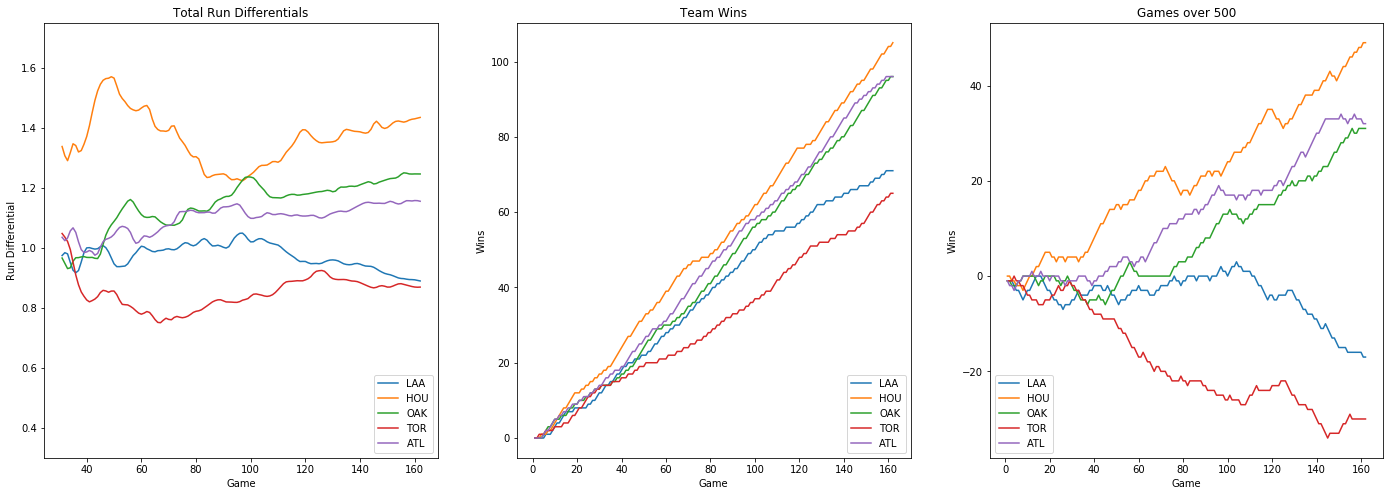

In [193]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24,8))
ax1.set_ylim(0.3,1.75)
ax1.set_title('Total Run Differentials')
ax1.set_ylabel('Run Differential')
ax1.set_xlabel('Game')

ax2.set_title('Team Wins')
ax2.set_ylabel('Wins')
ax2.set_xlabel('Game')

ax3.set_title('Games over 500')
ax3.set_ylabel('Wins')
ax3.set_xlabel('Game')

for team in teams[:5]:
    df = pd.read_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv")
    X = df['Gm#'].values[30:]
    y = gaussian_filter1d(df['Delta_Percentage'].values[30:],sigma=1)
    ax1.plot(X,y,label=team)
    
    X2 = df['Gm#'].values
    y2 = gaussian_filter1d(df['Wins_Total'].values,sigma=1)
    ax2.plot(X2,y2,label=team)
    
    X3 = X2
    y3 = gaussian_filter1d(df['Games_Over'].values,sigma=1)
    ax3.plot(X3,y3,label=team)
    
#plt.ylim(0,1.75)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower left')
#plt.show()

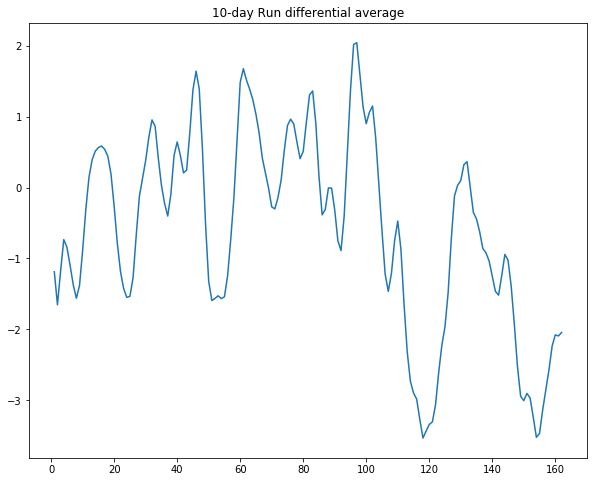

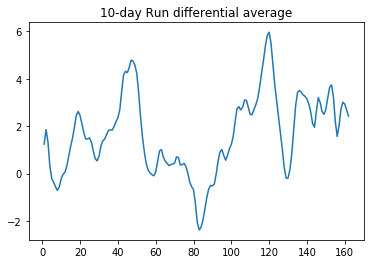

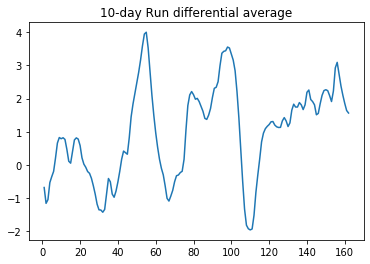

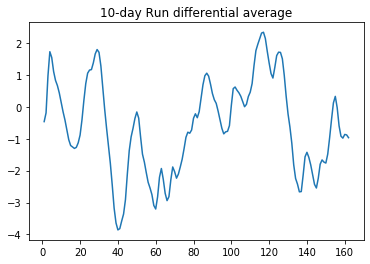

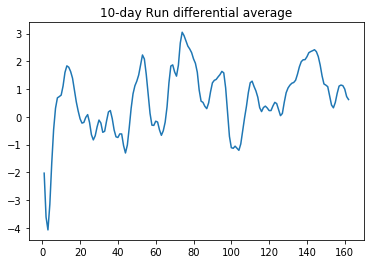

In [194]:
plt.figure(figsize=(10,8))
for team in teams[:5]:
    df = pd.read_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv")
    X = df['Gm#'].values
    y = get_avg_rd(df,avg_games=10)
    y_filter = gaussian_filter1d(y,sigma=1)
    #plt.plot(X,y,label=team)
    plt.plot(X,y_filter,label=team)
    plt.title("10-day Run differential average")
    plt.show()

In [ ]:
#Put DataFrames into memory
df = pd.read_csv("2019_all.csv")
team_runs = {}
for team in teams:
    team_runs[team] = pd.read_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv")


In [251]:
#compare team avg run differential and outcome
"""
Create the Dataset"""
X = []
y = df['Home_Win'].values
for i in range(len(df)):
    home_stats = np.ravel(team_runs[df.loc[i][2]].loc[df['Date'] == df.loc[i][0]].values[:,2:])
    away_stats = np.ravel(team_runs[df.loc[i][3]].loc[df['Date'] == df.loc[i][0]].values[:,2:])
    X.append(np.concatenate([home_stats, away_stats]))
